In [1]:
%pylab inline
import gwpy
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import astropy.units as u
import astropy.cosmology
import swyft
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers
import torch
from astropy.cosmology import Planck18, z_at_value, Planck13, Planck15
from scipy.integrate import quad
from scipy import interpolate
from astropy.constants import pc, c
import scipy
import jax
from jaxinterp2d import interp2d
import seaborn as sns
from jax import jit
import jax.numpy as jnp
from jax import device_get
import numpyro
import arviz as az
import numpyro.distributions as dist
from gwpy.timeseries import TimeSeries
from numpyro.infer import MCMC, NUTS
import torch.nn as nn
import torch.nn.functional as F
np.random.seed(3407)
jax.config.update("jax_enable_x64", True)
sns.set(style='ticks', context='notebook', font='serif', 
        font_scale=1.5, palette='deep')
rc_params = {'backend': 'pdf',
             'axes.labelsize': 24,
             'axes.titlesize': 32,
             'font.size': 18,
             'legend.fontsize': 18,
             'xtick.labelsize': 24,
             'ytick.labelsize': 24,
             'font.family': 'serif',
             'font.sans-serif': ['Bitstream Vera Sans'],
             'font.serif': ['Times New Roman'],
             'text.usetex':True,
            }
plt.rcParams["text.usetex"] = "true"

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
__all__ = ['Bounded_2d_kde', 'Bounded_1d_kde', 'kdeplot']

import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pandas as pd

class Bounded_1d_kde(ss.gaussian_kde):
    """ Represents a one-dimensional Gaussian kernel density estimator
    for a probability distribution function that exists on a bounded
    domain.

    Authorship: Ben Farr, LIGO
    """

    def __init__(self, pts, x_min=None, x_max=None, *args, **kwargs):
        """Initialize with the given bounds.  Either ``low`` or
        ``high`` may be ``None`` if the bounds are one-sided.  Extra
        parameters are passed to :class:`gaussian_kde`.

        :param x_min: The lower x domain boundary.

        :param x_max: The upper x domain boundary.
        """
        pts = np.atleast_1d(pts)

        assert pts.ndim == 1, 'Bounded_1d_kde can only be one-dimensional'

        super(Bounded_1d_kde, self).__init__(pts.T, *args, **kwargs)

        self._x_min = x_min
        self._x_max = x_max

    @property
    def x_min(self):
        """The lower bound of the x domain."""
        return self._x_min

    @property
    def x_max(self):
        """The upper bound of the x domain."""
        return self._x_max

    def evaluate(self, pts):
        """Return an estimate of the density evaluated at the given
        points."""
        pts = np.atleast_1d(pts)
        assert pts.ndim == 1, 'points must be one-dimensional'

        x = pts.T
        pdf = super(Bounded_1d_kde, self).evaluate(pts.T)
        if self.x_min is not None:
            pdf += super(Bounded_1d_kde, self).evaluate(2*self.x_min - x)

        if self.x_max is not None:
            pdf += super(Bounded_1d_kde, self).evaluate(2*self.x_max - x)

        return pdf

    def __call__(self, pts):
        pts = np.atleast_1d(pts)
        out_of_bounds = np.zeros(pts.shape[0], dtype='bool')

        if self.x_min is not None:
            out_of_bounds[pts < self.x_min] = True
        if self.x_max is not None:
            out_of_bounds[pts > self.x_max] = True

        results = self.evaluate(pts)
        results[out_of_bounds] = 0.
        return results


# The following routine, Bounded_2d_kde, was copied from
# https://git.ligo.org/publications/gw190412/gw190412-discovery/-/blob/851f91431b7c36e7ea66fa47e8516f2aef9d7daf/scripts/bounded_2d_kde.py
class Bounded_2d_kde(ss.gaussian_kde):
    r"""Represents a two-dimensional Gaussian kernel density estimator
    for a probability distribution function that exists on a bounded
    domain."""

    def __init__(self, pts, x_min=None, x_max=None, y_min=None, y_max=None,
                 *args, **kwargs):
        """Initialize with the given bounds.  Either ``low`` or
        ``high`` may be ``None`` if the bounds are one-sided.  Extra
        parameters are passed to :class:`gaussian_kde`.

        :param x_min: The lower x domain boundary.

        :param x_max: The upper x domain boundary.

        :param y_min: The lower y domain boundary.

        :param y_max: The upper y domain boundary.
        """
        pts = np.atleast_2d(pts)

        assert pts.ndim == 2, 'Bounded_kde can only be two-dimensional'

        super(Bounded_2d_kde, self).__init__(pts.T, *args, **kwargs)

        self._x_min = x_min
        self._x_max = x_max
        self._y_min = y_min
        self._y_max = y_max

    @property
    def x_min(self):
        """The lower bound of the x domain."""
        return self._x_min

    @property
    def x_max(self):
        """The upper bound of the x domain."""
        return self._x_max

    @property
    def y_min(self):
        """The lower bound of the y domain."""
        return self._y_min

    @property
    def y_max(self):
        """The upper bound of the y domain."""
        return self._y_max

    def evaluate(self, pts):
        """Return an estimate of the density evaluated at the given
        points."""
        pts = np.atleast_2d(pts)
        assert pts.ndim == 2, 'points must be two-dimensional'

        x, y = pts.T
        pdf = super(Bounded_2d_kde, self).evaluate(pts.T)
        if self.x_min is not None:
            pdf += super(Bounded_2d_kde, self).evaluate([2*self.x_min - x, y])
        if self.x_max is not None:
            pdf += super(Bounded_2d_kde, self).evaluate([2*self.x_max - x, y])
        if self.y_min is not None:
            pdf += super(Bounded_2d_kde, self).evaluate([x, 2*self.y_min - y])
        if self.y_max is not None:
            pdf += super(Bounded_2d_kde, self).evaluate([x, 2*self.y_max - y])
        if self.x_min is not None:
            if self.y_min is not None:
                pdf += super(Bounded_2d_kde, self).evaluate([2*self.x_min - x,
                                                             2*self.y_min - y])
            if self.y_max is not None:
                pdf += super(Bounded_2d_kde, self).evaluate([2*self.x_min - x,
                                                             2*self.y_max - y])
        if self.x_max is not None:
            if self.y_min is not None:
                pdf += super(Bounded_2d_kde, self).evaluate([2*self.x_max - x,
                                                             2*self.y_min - y])
            if self.y_max is not None:
                pdf += super(Bounded_2d_kde, self).evaluate([2*self.x_max - x,
                                                             2*self.y_max - y])
        return pdf

    def __call__(self, pts):
        pts = np.atleast_2d(pts)
        out_of_bounds = np.zeros(pts.shape[0], dtype='bool')

        if self.x_min is not None:
            out_of_bounds[pts[:, 0] < self.x_min] = True
        if self.x_max is not None:
            out_of_bounds[pts[:, 0] > self.x_max] = True
        if self.y_min is not None:
            out_of_bounds[pts[:, 1] < self.y_min] = True
        if self.y_max is not None:
            out_of_bounds[pts[:, 1] > self.y_max] = True

        results = self.evaluate(pts)
        results[out_of_bounds] = 0.
        return results


# ############################################################################
# PLOTTING

def kdeplot_2d_clevels(xs, ys, levels=10, fill=False, n_grid=128, **kws):
    """ Plot contours at specified credible levels.

    Arguments
    ---------
    xs: array
        samples of the first variable.
    ys: array
        samples of the second variable, drawn jointly with `xs`.
    levels: float, array
        if float, interpreted as number of credible levels to be equally 
        spaced between (0, 1); if array, interpreted as list of credible
        levels.
    x_min: float
        lower bound for abscissa passed to Bounded_2d_kde (optional).
    xigh: float
        upper bound for abscissa passed to Bounded_2d_kde (optional).
    y_min: float
        lower bound for ordinate passed to Bounded_2d_kde (optional).
    y_max: float
        upper bound for ordinate passed to Bounded_2d_kde (optional).
    ax: Axes
        matplotlib axes on which to plot (optional).
    kwargs:
        additional arguments passed to plt.contour().
    """
    try:
        xs = xs.values.astype(float)
        ys = ys.values.astype(float)
    except AttributeError:
        pass

    if np.all(~np.isfinite(xs)) or np.all(~np.isfinite(ys)):
        return None
    
    # construct credible levels
    try:
        len(levels)
        f = 1 - np.array(levels)
    except TypeError:
        f = np.linspace(0, 1, levels+1, endpoint=True)[1:-1]
    if fill:
        # f = np.concatenate([f, [1]])
        kws['extend'] = 'max'
    
    # estimate bounded KDE from samples
    if kws.get('auto_bound', False):
        kws['x_min'] = min(xs)
        kws['x_max'] = max(xs)
        kws['y_min'] = min(ys)
        kws['y_max'] = max(ys)
    ks = ['x_min', 'x_max', 'y_min', 'y_max', 'bw_method', 'weights']
    kde_kws = {k: kws.pop(k, None) for k in ks}
    k = Bounded_2d_kde(np.column_stack((xs, ys)), **kde_kws)
    
    # evaluate KDE on all points
    p = k(np.column_stack((xs, ys)))
    
    # the levels passed to the contour function have to be the
    # values of the KDE at corresponding to the quantiles
    # first get the order of the samples sorted by KDE value
    # then find the values that correspond to the thresholds
    i = np.argsort(p)
    l = np.array([p[i[min(int(np.round(ff*len(p))), len(i)-1)]] for ff in f])
    
    # construct grid of x and y values based on the
    # range of the samples
    x_hi, x_lo = np.percentile(xs, 99), np.percentile(xs, 1)
    y_hi, y_lo = np.percentile(ys, 99), np.percentile(ys, 1)
    
    Dx = x_hi - x_lo
    Dy = y_hi - y_lo

    x = np.linspace(x_lo-0.1*Dx, x_hi+0.1*Dx, n_grid)
    y = np.linspace(y_lo-0.1*Dy, y_hi+0.1*Dy, n_grid)

    # construct grids and evaluate KDE
    XS, YS = np.meshgrid(x, y, indexing='ij')
    ZS = k(np.column_stack((XS.flatten(), YS.flatten()))).reshape(XS.shape)

    ax = kws.pop('ax', plt.gca())
    p = kws.get('cmap', kws.pop('palette', None))
    if p is not None:
        kws['colors'] = None
        kws['cmap'] = p
    else:
        kws['colors'] = kws.get('colors', 
                                [kws.pop('color', kws.pop('c', None)),])
    if fill:
        ax.contourf(XS, YS, ZS, levels=l, **kws)
    else:
        ax.contour(XS, YS, ZS, levels=l, **kws)


def kdeplot(x, y=None, **kws):
    
    if np.all(~np.isfinite(x)):
        return None

    if 'hue' in kws:
        hues = kws.pop('hue')
        hues_unique = sorted(hues.unique())
        n_hues = len(hues_unique)
        
        if 'palette' in kws:
            palette = sns.color_palette(kws.pop('palette'), n_colors=n_hues)
        else:
            # attempt to use seaborn's logic for determining the color palette
            # (this will fail if seaborn changes it's internal API)
            try:
                from seaborn.distributions import _DistributionPlotter
                df = pd.DataFrame(dict(x=x, y=y, hue=hues))
                if y is None:
                    df = df.drop(columns='y')
                    v = dict(x='x', hue='hue')
                else:
                    v = dict(x='x', y='y', hue='hue')
                dp = _DistributionPlotter(data=df, variables=v)
                palette = [dp._hue_map(l) for l in dp._hue_map.levels]
            except Exception:
                if pd.api.types.is_numeric_dtype(hues_unique):
                    # Numeric: Use a sequential palette
                    palette = sns.color_palette("ch:", n_colors=n_hues)
                else:
                    # Categorical: Use a qualitative palette
                    palette = sns.color_palette("deep", n_colors=n_hues)

        for hue, color in zip(hues_unique, palette):
            xs_hue = x[hues == hue]
            if y is None:
                ys_hue = None
            else:
                ys_hue = y[hues == hue]
            kdeplot(xs_hue, ys_hue, **kws, color=color)
            plt.plot([], [], c=color, label=hue)
        plt.legend();
        return
    
    if y is not None:
        return kdeplot_2d_clevels(x, y, **kws)
    
    if kws.pop('auto_bound', False):
        kws['x_min'] = min(x)
        kws['x_max'] = max(x)
    kde_kws = {k: kws.pop(k, None) for k in 
               ['x_min', 'x_max', 'bw_method', 'weights']}
    k = Bounded_1d_kde(x, **kde_kws)
    
    x_hi, x_lo = np.percentile(x, 99), np.percentile(x, 1)
    
    Dx = x_hi - x_lo
    xgrid = np.linspace(x_lo-0.1*Dx, x_hi+0.1*Dx, kws.pop('n_grid', 128))
    ygrid = k(xgrid)
    ax = kws.pop('ax', plt.gca())
    ax.plot(xgrid, ygrid, **kws)
    
    if kws.get('fill', False):
        alpha = kws.get('alpha', 0.5)
        ax.fill_between(xgrid, 0, ygrid, alpha=alpha, **kws)

In [3]:
# Define simulator parameters
f_low = 10
f_high = 200
Delta_f = 1./32
N_bins = int((f_high-f_low)/Delta_f) + 1
freq = np.linspace(f_low, f_high+Delta_f, N_bins)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=len(freq), bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(f_low, f_high, N_bins)
        self.sample_z = swyft.RectBoundSampler([stats.uniform(-12, 4), #omega stats.uniform(-12,5)
                                                stats.uniform(0,4)], #alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        #denomenator = (3*H0**2)**2 * 8
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = 10**z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m)
        #sigma = graph.node('sigma',self.sigma)

In [4]:

class AE(swyft.SwyftModule,swyft.AdamWReduceLROnPlateau):
    def __init__(self, lr = 1e-5, gamma=0.98, weight_decay=1e-5,lr_scheduler_factor=0.05):
        super().__init__()
        
        marginals = ((0,1), )
        self.learning_rate = lr
        self.lr_scheduler_factor = lr_scheduler_factor
        self.weight_decay = weight_decay
        self.gamma = gamma
        # AE-Summarizer
        self.summarizer =  nn.Sequential(
            nn.Linear(6081, 4096),
            nn.GELU(),
            nn.Linear(4096, 2048),
            nn.GELU(),
            nn.Linear(2048, 1024),
            nn.GELU(),
            nn.Linear(1024, 256),
            nn.GELU(),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Linear(128, 32),
            nn.GELU(),
            nn.Linear(32, 16),
            nn.GELU(),
            nn.Linear(16, 8),
            nn.GELU(),
            nn.Linear(8, 4),
            nn.GELU(),
            # nn.Linear(8, 4),
            # nn.GELU(),
        )

        
        self.logratios_1D = swyft.LogRatioEstimator_1dim(
            num_features=4,  # Number of features in compressed x (simulated observation)
            num_params=2,    # Two parameters to infer: alpha and omega
            varnames='z', 
            dropout = 0# Names of the parameters
            # Number of neural network blocks
        )
            
        self.logratios_2D = swyft.LogRatioEstimator_Ndim(num_features = 4, 
                                                       marginals = marginals, varnames = 'z', num_blocks = 4,  dropout = 0)
        
            
    def forward(self, A, B):
        s = self.summarizer(A['x'])

        return self.logratios_1D(s, B['z']),  s, self.logratios_2D(s, B['z'])

In [5]:
class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        )

    def forward(self, x):
        return x + self.block(x)




class ResMLPAE(swyft.SwyftModule,swyft.AdamW):
    def __init__(self, lr = 1e-5, gamma=0.98, weight_decay=1e-5):
        super().__init__()
        
        marginals = ((0,1), )
        self.learning_rate = lr
        self.weight_decay = weight_decay
        self.gamma = gamma

        # AE-Summarizer
        self.summarizer = nn.Sequential(
            nn.Linear(6081, 4096),  nn.GELU(),
            ResBlock(4096),  nn.GELU(),
            
            nn.Linear(4096, 2048),  nn.GELU(),
            ResBlock(2048),  nn.GELU(),

            nn.Linear(2048, 1024),  nn.GELU(),
            ResBlock(1024),  nn.GELU(),
    

            nn.Linear(1024, 512),  nn.GELU(),
            ResBlock(512),  nn.GELU(),

            nn.Linear(512, 256),  nn.GELU(),
            ResBlock(256),  nn.GELU(),

            nn.Linear(256, 128),  nn.GELU(),
            ResBlock(128),  nn.GELU(),
        
            nn.Linear(128, 32), nn.GELU(),
            ResBlock(32),  nn.GELU(),
        
            nn.Linear(32, 16),  nn.GELU(),
            ResBlock(16),  nn.GELU(),

            nn.Linear(16, 8),  nn.GELU(),
            ResBlock(8),  nn.GELU(),

            nn.Linear(8, 4),  nn.GELU(),
            ResBlock(4), 

            # nn.Linear(16, 8),  nn.GELU(),
            # ResBlock(8),  nn.GELU(),
            
            # nn.Linear(8, 4),  nn.GELU(),
            # ResBlock(4),  nn.GELU(),
        
            # nn.Linear(16, 2), nn.GELU(),
            # ResBlock(2),  nn.GELU()
        )

     

        
        self.logratios_1D = swyft.LogRatioEstimator_1dim(
            num_features=4,  # Number of features in compressed x (simulated observation)
            num_params=2,    # Two parameters to infer: alpha and omega
            varnames='z', 
            dropout = 0# Names of the parameters
            # Number of neural network blocks
        )
            
        self.logratios_2D = swyft.LogRatioEstimator_Ndim(num_features = 4, 
                                                       marginals = marginals, varnames = 'z', num_blocks = 4,  dropout = 0)
        
            
    def forward(self, A, B):
        s = self.summarizer(A['x'])

        return self.logratios_1D(s, B['z']),  s, self.logratios_2D(s, B['z'])


In [6]:
def preprocess_whiten(y_raw, sigma_raw):
    """
    y_raw: (batch_size, 4096)
    sigma_raw: (4096,) or (batch_size, 4096)
    """

    # 1. Whitening
    weight = sigma_raw**-2/(np.sum(sigma_raw**-2))
    y_whitened = y_raw# * weight

    # 2. Log compression (可选，但通常很有用)
    y_log = np.log10(np.abs(y_whitened)/sigma_raw)
    #y_log = np.log10(np.abs(y_raw/sigma_raw))
    # MIN = np.min(y_log, axis=-1).reshape([-1, 1])
    # MAX = np.max(y_log, axis=-1).reshape([-1, 1])
    # y_log = (y_log - MIN)/(MAX - MIN)
    return y_log

In [8]:
# Sample from Simulator

n_samples = 50_000
fref = 25
CE_PSD = np.genfromtxt("../Abby/data/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("../Abby/data/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
sigma = sim.sigma()

In [91]:
sims = sim.sample(N = n_samples)
sims['x'] = preprocess_whiten(sims['x'] , sigma)

# idx = sims['x']<=0
# #sims['x'] = np.where(sims['x'] < 0, sigma, sims['x'])
# sims['x'] = np.abs(sims['x'])/sigma
# #sims['x'] = np.log10(sims['x']/sigma)

# # mu = np.mean(sims['x'], axis=0)
# # std = np.std(sims['x'], axis=0)

# # # sims['x'] = (sims['x']-mu)/std
# Max = np.max(sims['x'], axis=1).reshape([n_samples, 1])
# Min = np.min(sims['x'], axis=1).reshape([n_samples, 1])
# sims['x'] = (sims['x'] - Min)/(Max - Min)
# # This step is very important!
# Maybe we can find a better way to do it!
#sims['x'] = np.log10(np.abs(sims['x'])/sigma)

100%|██████████████████████████████████| 50000/50000 [00:58<00:00, 855.03it/s]


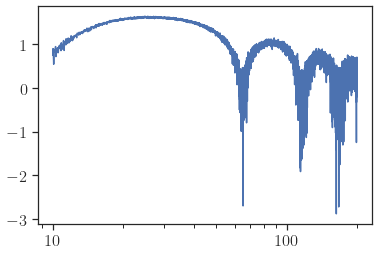

In [92]:
plt.semilogx(sim.freq, sims['x'][1])

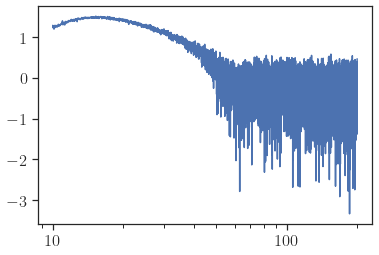

In [16]:
test_data = sim.sample(conditions={'z':[-10, 1.2]})
test_data['x'] = test_data['x'].reshape([1, 6081])
test_data['x'] = preprocess_whiten(test_data['x'] , sigma)
test_data['x'] = test_data['x'][0]
plt.semilogx(sim.freq, test_data['x'])

# MCMC result

In [90]:
def make_model(f, C_ij, sigma_ij):
    f_ref = 25
    # prior
    Omega = numpyro.sample('Omega_alpha', dist.LogUniform(1e-12,1e-8), sample_shape=(1,),rng_key=jax.random.PRNGKey(3407))

    alpha = numpyro.sample('alpha', dist.Uniform(0,4), sample_shape=(1,),rng_key=jax.random.PRNGKey(3407))
    
    Omega_cosmo = Omega*(f/f_ref)**alpha
    logp = -jnp.sum((C_ij - Omega_cosmo)**2/sigma_ij**2)/2

    numpyro.factor('log_likelihood', logp)

In [111]:
nmcmc = 1000
nchain = 4

kernel = NUTS(make_model)
mcmc = MCMC(kernel, num_warmup = nmcmc, num_samples = nmcmc, num_chains = nchain)
mcmc.run(jax.random.PRNGKey(3407), sim.freq, test_data['x'], sigma)

/tmp/ipykernel_1805101/309124204.py:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup = nmcmc, num_samples = nmcmc, num_chains = nchain)

sample: 100%|██████████| 2000/2000 [00:04<00:00, 408.72it/s, 7 steps of size 4.56e-01. acc. prob=0.95]

sample: 100%|██████████| 2000/2000 [00:03<00:00, 629.40it/s, 3 steps of size 5.41e-01. acc. prob=0.93]

sample: 100%|██████████| 2000/2000 [00:02<00:00, 672.17it/s, 3 steps of size 5.90e-01. acc. prob=0.90]

sample: 100%|██████████| 2000/2000 [00:03<00:00, 647.47it/s, 7 steps of size 4.84e-01. acc. prob=0.94] 


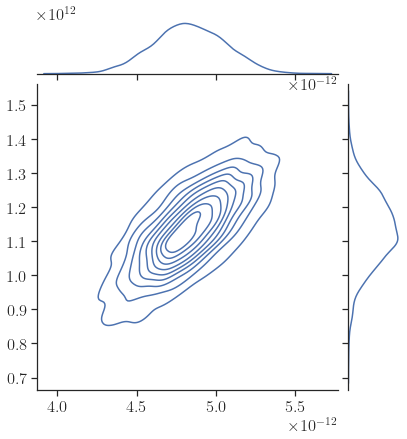

In [112]:
result = az.from_numpyro(mcmc)
Omega_MCMC = np.asarray(result['posterior']['Omega_alpha']).reshape([-1])
alpha_MCMC = np.asarray(result['posterior']['alpha']).reshape([-1])
sns.jointplot(x=Omega_MCMC, y=alpha_MCMC, kind="kde")

In [114]:
np.std(Omega_MCMC), np.std(alpha_MCMC)

(2.2606255056998172e-13, 0.10546162425733319)

# SBI

In [94]:
dm = swyft.SwyftDataModule(sims[:], val_fraction = 0.2, batch_size = 1024)

lr_monitor = LearningRateMonitor(logging_interval='step')
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta = 0., patience=3, verbose=True, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='/scratch/haowen.zhong/SBI/logs/', filename='SBI_{epoch}_{val_loss:.2f}_{train_loss:.2f}', mode='min')
logger = pl_loggers.TensorBoardLogger(save_dir='/scratch/haowen.zhong/SBI/logs/', name='AE_logs', version=None)

# auto_lr_find=True, 
trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 300, devices=1,   auto_lr_find=True, logger=logger, callbacks=[lr_monitor, early_stopping_callback, checkpoint_callback], precision=64)
network = AE(lr=8e-6, weight_decay=1e-5, gamma=0.98)#AE(lr=2e-5)#UNet(lr=2e-5, weight_decay=0.01)
trainer.fit(network, dm)#ckpt_path="./logs/AE_logs/version_67/checkpoints/epoch=46-step=1504.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type                   | Params
--------------------------------------------------------
0 | summarizer   | Sequential             | 35.7 M
1 | logratios_1D | LogRatioEstimator_1dim | 35.2 K
2 | logratios_2D | LogRatioEstimator_Ndim | 34.8 K
-------------------

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches

Epoch 0:  80%|██████▍ | 40/50 [00:03<00:00, 11.69it/s, loss=0.00219, v_num=45]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|███████▊| 49/50 [00:03<00:00, 12.46it/s, loss=0.00219, v_num=45]
Epoch 0: 100%|█| 50/50 [00:03<00:00, 12.53it/s, loss=0.00219, v_num=45, val_lo
Epoch 1:  80%|▊| 40/50 [00:03<00:00, 10.38it/s, loss=-0.000377, v_num=45, val_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                         | 0/10 [00:00<?, ?it/s]
Epoch 1:  82%|▊| 41/50 [00:03<00:00, 10.45it/s, loss=-0.000377, v_num=45, val_
Epoch 1:  84%|▊| 42/50 [00:03<00:00, 10.55it/s, loss=-0.000377, v_num=45, val_
Epoch 1:  86%|▊| 43/50 [00:04<00:00, 10.63it/s, loss=-0.000377, v_num=45, val_
Epoch 1:  88%|▉| 44/50 [00:04<00:00, 10.71it/s, loss=-0.000377, v_num=45, val_
Epoch 1:  90%|▉| 45/50 [00:04<00:00, 10.80it/s, loss=-0.000377, v_num=45, val_
Epoch 1:  92%|▉| 46/50 [00:04<00:00, 10.90it/s, loss=-0.000377, v_num=45, val_
Epoch 1:  94%|▉| 47/50 [00:04<00:00, 10.97it/s, loss=-0.000377, v_num

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.

Reloading best model: /scratch/haowen.zhong/SBI/logs/AE_logs/version_45/checkpoints/epoch=75-step=3040.ckpt


In [95]:
ckpt = torch.load(
    "/scratch/haowen.zhong/SBI/logs/AE_logs/version_45/checkpoints/epoch=75-step=3040.ckpt",
    map_location=torch.device('cpu')
)
network = AE()
network.load_state_dict(ckpt['state_dict'])
network.eval()

trainer = swyft.SwyftTrainer(accelerator = 'cpu', max_epochs = 50, auto_lr_find=True, precision=64)

/local/haowen.zhong/ipykernel_1316071/3012009107.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(
GPU available: True (cuda), used: False
TPU available

In [71]:
# ckpt = torch.load(
#     "/scratch/haowen.zhong/SBI/logs/AE_logs/version_21/checkpoints/epoch=146-step=5880.ckpt",
#     map_location=torch.device('cpu')
# )
# network = VAE()
# network.load_state_dict(ckpt['state_dict'])
# network.eval()
# lr_monitor = LearningRateMonitor(logging_interval='step')
# early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta = 0., patience=3, verbose=False, mode='min')
# checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='/scratch/haowen.zhong/SBI/logs/', filename='CC_{epoch}_{val_loss:.2f}_{train_loss:.2f}', mode='min')
# logger = pl_loggers.TensorBoardLogger(save_dir='/scratch/haowen.zhong/SBI/logs/', name='AE_logs', version=None)

# trainer = swyft.SwyftTrainer(accelerator = 'cpu', max_epochs = 50, auto_lr_find=True, logger=logger, callbacks=[lr_monitor, early_stopping_callback, checkpoint_callback], precision=64)

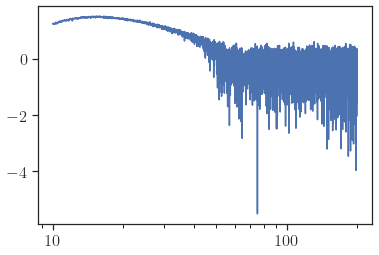

In [19]:
test_data = sim.sample(conditions={'z':[-10, 1.2]})
#test_data['x'] = preprocess_whiten(test_data['x'] , sigma)
test_data['x'] = test_data['x'].reshape([1, 6081])
test_data['x'] = preprocess_whiten(test_data['x'] , sigma)
test_data['x'] = test_data['x'][0]
plt.semilogx(sim.freq, test_data['x'])

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


Predicting DataLoader 0: 100%|████████████████| 98/98 [00:03<00:00, 30.11it/s]


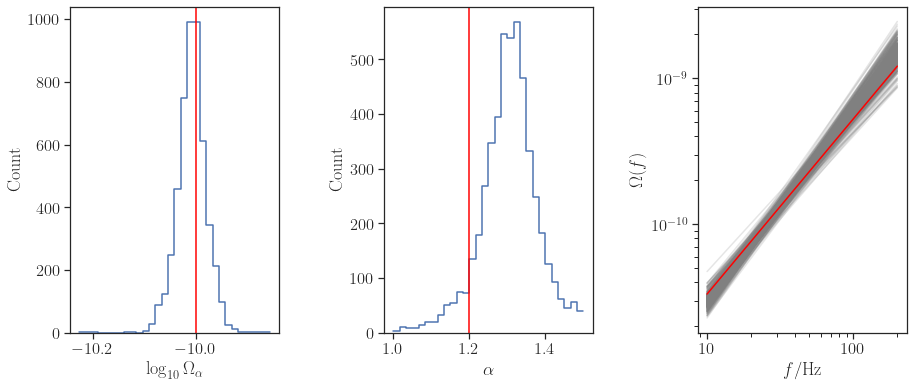

In [97]:
# Define priors
omega_prior = stats.uniform(-10.3, 0.5)#stats.uniform(-9.2, 0.4)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(1,  0.5)          # Uniform distribution for alpha

# Sample 1000 points from the priors
z_omega = omega_prior.rvs(100000)
z_alpha = alpha_prior.rvs(100000)

z_samps = np.column_stack((z_omega, z_alpha))

# Create prior samples
prior_samples = swyft.Samples(z = z_samps)
predictions = trainer.infer(network, test_data, prior_samples)


ln_r = np.asarray(predictions[0].logratios)
r_1 = np.exp(ln_r[:, 0])
r_2 = np.exp(ln_r[:, 1])
post_Omega = np.random.choice(z_samps[:, 0], size=5000, p = r_1/np.sum(r_1))
post_alpha = np.random.choice(z_samps[:, 1], size=5000, p = r_2/np.sum(r_2))
plt.figure(figsize=(15, 6))
plt.subplot(131)
#sns.kdeplot(post_Omega)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
#plt.xscale("log")
plt.axvline(test_data['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
#sns.kdeplot(post_alpha)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
    #plt.loglog(sim.freq, post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
    
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**test_data['z'][0]*(sim.freq/sim.fref)**test_data['z'][1], color="red")
#plt.loglog(sim.freq, test_data['z'][0, 0]*(sim.freq/sim.fref)**test_data['z'][0, 1], color="red")

In [98]:
np.mean(10**post_Omega), np.std(10**(post_Omega)), np.mean(10**post_Omega)/np.std(10**(post_Omega))

(9.835452453269129e-11, 6.319223592028706e-12, 15.564336836689748)

/local/haowen.zhong/ipykernel_1316071/1926431257.py:271: UserWarning: The following kwargs were not used by contour: 'auto_bound', 'linewidth'
  ax.contour(XS, YS, ZS, levels=l, **kws)


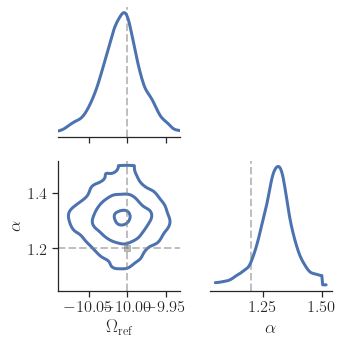

In [99]:
df = pd.DataFrame({r'$\Omega_\mathrm{ref}$': post_Omega, r'$\alpha$': post_alpha})

cls = [0.9, 0.6, 0.1]
p1 = sns.color_palette("light:C0", as_cmap=True)
hue_kws = dict(
    levels=[cls, cls],
    fill=[False, False],
    color=['#4c72b0', '#dd8452'],
    linestyles=['-', '-'],
    linewidths=[3, 3],
    alpha=[1, 1],
    zorder=[1, 1]
)
cornerresult = sns.PairGrid(df, vars=[r"$\Omega_\mathrm{ref}$", r"$\alpha$"],
             corner=True,
             palette=['C0', 'C1'],
             hue_kws=hue_kws,
             diag_sharey=False)
cornerresult.map_diag(kdeplot, auto_bound=True, linewidth=3)
cornerresult.map_lower(kdeplot, auto_bound=True, linewidth=3)


diag_index = [0, 3]
joint_index = [2]
diag_truths = [test_data['z'][0], test_data['z'][1]] 
joint_truths_h = [test_data['z'][1]]
joint_truths_v = [test_data['z'][0]]
for i, ax in enumerate(cornerresult.axes.ravel()[joint_index]):
    ax.axvline(joint_truths_v[i], ls='--', linewidth=2, c='gray', alpha=0.5)
    ax.axhline(joint_truths_h[i], ls='--', linewidth=2, c='gray', alpha=0.5)
    ax.plot(joint_truths_v[i], joint_truths_h[i], marker="s", color="gray", alpha=0.5)
for i, ax in enumerate(cornerresult.axes.ravel()[diag_index]):
    ax.axvline(diag_truths[i], ls='--', linewidth=2, c='gray', alpha=0.5)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|████████████████| 98/98 [00:03<00:00, 29.56it/s]


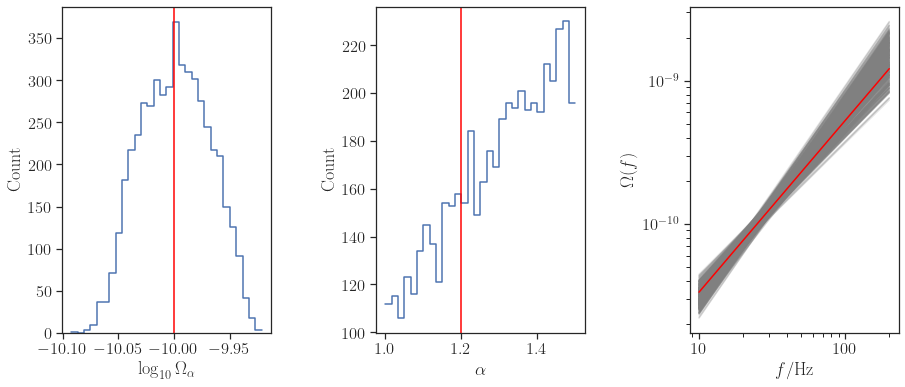

In [100]:
omega_prior = stats.uniform(-10.3, 0.5)#stats.uniform(-9.2, 0.4)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(1,  0.5)        # Uniform distribution for alpha

# Sample 1000 points from the priors
z_omega = omega_prior.rvs(100000)
z_alpha = alpha_prior.rvs(100000)

z_samps = np.column_stack((z_omega, z_alpha))

# Create prior samples
prior_samples = swyft.Samples(z = z_samps)
predictions = trainer.infer(network, test_data, prior_samples)
ln_r = np.asarray(predictions[1].logratios)
r = np.exp(ln_r).reshape([-1])

post_idx = np.random.choice(np.arange(0, 100000, 1), size=5000, p = r/np.sum(r))
post_Omega = z_samps[post_idx, 0]
post_alpha = z_samps[post_idx, 1]
plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**test_data['z'][0]*(sim.freq/sim.fref)**test_data['z'][1], color="red")

/local/haowen.zhong/ipykernel_1316071/1926431257.py:271: UserWarning: The following kwargs were not used by contour: 'auto_bound', 'linewidth'
  ax.contour(XS, YS, ZS, levels=l, **kws)


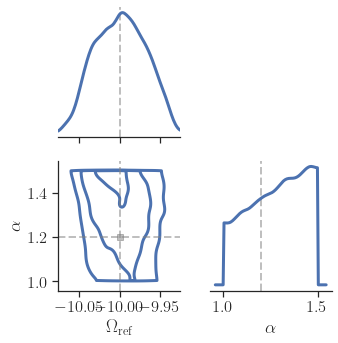

In [101]:
df = pd.DataFrame({r'$\Omega_\mathrm{ref}$': post_Omega, r'$\alpha$': post_alpha})

cls = [0.9, 0.6, 0.1]
p1 = sns.color_palette("light:C0", as_cmap=True)
hue_kws = dict(
    levels=[cls, cls],
    fill=[False, False],
    color=['#4c72b0', '#dd8452'],
    linestyles=['-', '-'],
    linewidths=[3, 3],
    alpha=[1, 1],
    zorder=[1, 1]
)
cornerresult = sns.PairGrid(df, vars=[r"$\Omega_\mathrm{ref}$", r"$\alpha$"],
             corner=True,
             palette=['C0', 'C1'],
             hue_kws=hue_kws,
             diag_sharey=False)
cornerresult.map_diag(kdeplot, auto_bound=True, linewidth=3)
cornerresult.map_lower(kdeplot, auto_bound=True, linewidth=3)


diag_index = [0, 3]
joint_index = [2]
diag_truths = [test_data['z'][0], test_data['z'][1]] 
joint_truths_h = [test_data['z'][1]]
joint_truths_v = [test_data['z'][0]]
for i, ax in enumerate(cornerresult.axes.ravel()[joint_index]):
    ax.axvline(joint_truths_v[i], ls='--', linewidth=2, c='gray', alpha=0.5)
    ax.axhline(joint_truths_h[i], ls='--', linewidth=2, c='gray', alpha=0.5)
    ax.plot(joint_truths_v[i], joint_truths_h[i], marker="s", color="gray", alpha=0.5)
for i, ax in enumerate(cornerresult.axes.ravel()[diag_index]):
    ax.axvline(diag_truths[i], ls='--', linewidth=2, c='gray', alpha=0.5)

In [102]:
print(r"SBI sigma for Omega,", np.std(10**post_Omega))
#print(r"MCMC sigma for Omega,", np.std(Omega_MCMC))

SBI sigma for Omega, 7.068199270172605e-12


In [103]:
print(r"SBI sigma for Omega,", np.std(post_alpha))
#print(r"MCMC sigma for Omega,", np.std(Omega_MCMC))

SBI sigma for Omega, 0.14056139861879718


In [104]:
omega_prior = stats.uniform(-12, 4)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(0, 4)            # Uniform distribution for alpha

# Sample 1000 points from the priors
z_omega = omega_prior.rvs(10000)
z_alpha = alpha_prior.rvs(10000)
z_samps = np.column_stack((z_omega, z_alpha))
prior_samples = swyft.Samples(z = z_samps)


coverage_samples = trainer.test_coverage(network, sims[-1000:], prior_samples[:])

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|████████████████| 32/32 [00:00<00:00, 58.04it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint



Predicting DataLoader 0: 100%|██████████| 10000/10000 [06:20<00:00, 26.31it/s]


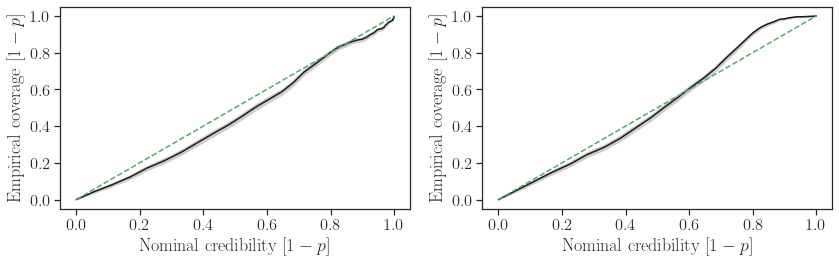

In [105]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
swyft.plot_pp(coverage_samples, "z[0]")
plt.subplot(122)
swyft.plot_pp(coverage_samples, "z[1]")
plt.tight_layout()

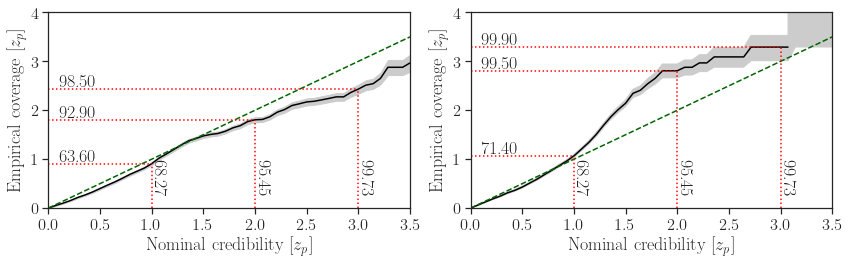

In [106]:
# zz-plot, emphasize high-credibility regionn and visualize uncertainties
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    swyft.plot_zz(coverage_samples, "z[%i]"%i, ax = axes[i])
plt.tight_layout()

# Second round

In [11]:
bounds = swyft.collect_rect_bounds(predictions[0], 'z', parshape=(2,), threshold=1e-4)
print(bounds)

NameError: name 'predictions' is not defined

In [108]:
# Sample from Simulator

n_samples = 100_000
fref = 25
sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=bounds)
sims = sim.sample(N = n_samples)
sims['x'] = preprocess_whiten(sims['x'] , sigma)

dm = swyft.SwyftDataModule(sims, val_fraction = 0.2, batch_size = 2048)
lr_monitor = LearningRateMonitor(logging_interval='step')
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta = 0., patience=3, verbose=False, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='/scratch/haowen.zhong/SBI/logs/', filename='rings_{epoch}_{val_loss:.2f}_{train_loss:.2f}', mode='min')
logger = pl_loggers.TensorBoardLogger(save_dir='/scratch/haowen.zhong/SBI/logs/', name='AE_logs', version=None)

100%|████████████████████████████████| 100000/100000 [01:57<00:00, 854.53it/s]


In [109]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 300, devices=1, auto_lr_find=True, logger=logger, callbacks=[lr_monitor, early_stopping_callback, checkpoint_callback], precision=64)
network = AE(lr=1e-6, weight_decay=1e-5, gamma=0.98)#AE(lr=2e-5)#UNet(lr=2e-5, weight_decay=0.01)
trainer.fit(network, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type                   | Params
--------------------------------------------------------
0 | summarizer   | Sequential             | 35.7 M
1 | logratios_1D | LogRatioEstimator_1dim | 35.2 K
2 | logratios_2D | LogRatioEstimator_Ndim | 34.8 K
-------------------

Sanity Checking DataLoader 0:  50%|██████▌      | 1/2 [00:00<00:00, 20.84it/s]

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  80%|██████▍ | 40/50 [00:05<00:01,  7.09it/s, loss=0.00676, v_num=46]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|███████▊| 49/50 [00:06<00:00,  7.57it/s, loss=0.00676, v_num=46]
Epoch 0: 100%|█| 50/50 [00:06<00:00,  7.58it/s, loss=0.00676, v_num=46, val_lo
Epoch 1:  80%|▊| 40/50 [00:05<00:01,  6.93it/s, loss=0.00613, v_num=46, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                         | 0/10 [00:00<?, ?it/s]
Epoch 1:  82%|▊| 41/50 [00:05<00:01,  6.98it/s, loss=0.00613, v_num=46, val_lo
Epoch 1:  84%|▊| 42/50 [00:05<00:01,  7.03it/s, loss=0.00613, v_num=46, val_lo
Epoch 1:  86%|▊| 43/50 [00:06<00:00,  7.09it/s, loss=0.00613, v_num=46, val_lo
Epoch 1:  88%|▉| 44/50 [00:06<00:00,  7.14it/s, loss=0.00613, v_num=46, val_lo
Epoch 1:  90%|▉| 45/50 [00:06<00:00,  7.19it/s, loss=0.00613, v_num=46, val_lo
Epoch 1:  92%|▉| 46/50 [00:06<00:00,  7.25it/s, loss=0.00613, v_num=46, val_lo
Epoch 1:  94%|▉| 47/50 [00:06<00:00,  7.29it/s, loss=0.00613, v_num=4

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|█| 50/50 [00:07<00:00,  6.37it/s, loss=-3.16, v_num=46, val_lo


/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.

Reloading best model: /scratch/haowen.zhong/SBI/logs/AE_logs/version_46/checkpoints/epoch=299-step=12000.ckpt


In [38]:
ckpt = torch.load(
    "/scratch/haowen.zhong/SBI/logs/AE_logs/version_46/checkpoints/epoch=299-step=12000.ckpt",
    map_location=torch.device('cpu')
)
network = AE()
network.load_state_dict(ckpt['state_dict'])
network.eval()

trainer = swyft.SwyftTrainer(accelerator = 'cpu', max_epochs = 50, auto_lr_find=True, precision=64)

/local/haowen.zhong/ipykernel_4053153/2550255930.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(
GPU available: True (cuda), used: False
TPU available

In [39]:
test_data['z']

[-10, 1.2]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


Predicting DataLoader 0: 100%|████████████████████████████████████████| 98/98 [00:03<00:00, 28.51it/s]


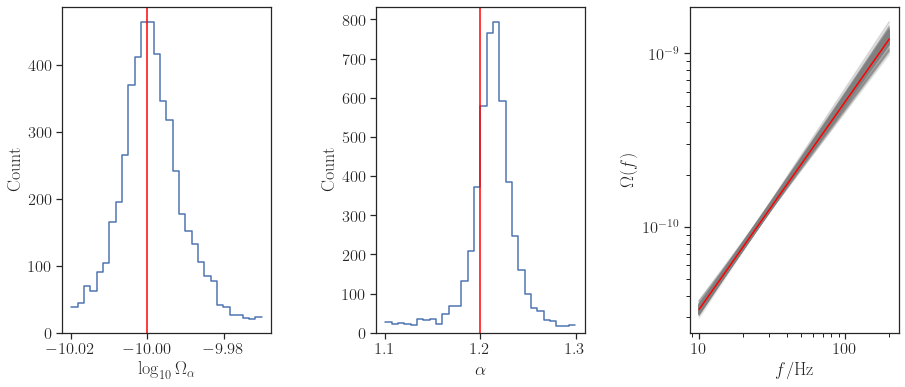

In [40]:
# Define priors
omega_prior = stats.uniform(-10.02, 0.05)#stats.uniform(-9.2, 0.4)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(1.1,  0.2)              # Uniform distribution for alpha

# Sample 1000 points from the priors
z_omega = omega_prior.rvs(100000)
z_alpha = alpha_prior.rvs(100000)

z_samps = np.column_stack((z_omega, z_alpha))

# Create prior samples
prior_samples = swyft.Samples(z = z_samps)
predictions = trainer.infer(network, test_data, prior_samples)


ln_r = np.asarray(predictions[0].logratios)
r_1 = np.exp(ln_r[:, 0])
r_2 = np.exp(ln_r[:, 1])
post_Omega = np.random.choice(z_samps[:, 0], size=5000, p = r_1/np.sum(r_1))
post_alpha = np.random.choice(z_samps[:, 1], size=5000, p = r_2/np.sum(r_2))
plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
    #plt.loglog(sim.freq, post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
    
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**test_data['z'][0]*(sim.freq/sim.fref)**test_data['z'][1], color="red")
#plt.loglog(sim.freq, test_data['z'][0, 0]*(sim.freq/sim.fref)**test_data['z'][0, 1], color="red")

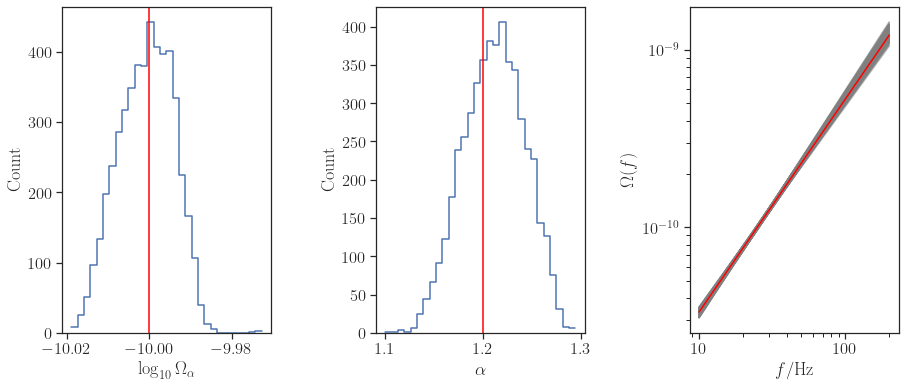

In [41]:
ln_r = np.asarray(predictions[1].logratios)
r = np.exp(ln_r).reshape([-1])

post_idx = np.random.choice(np.arange(0, 100000, 1), size=5000, p = r/np.sum(r))
post_Omega = z_samps[post_idx, 0]
post_alpha = z_samps[post_idx, 1]
plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**test_data['z'][0]*(sim.freq/sim.fref)**test_data['z'][1], color="red")

/local/haowen.zhong/ipykernel_4053153/1926431257.py:271: UserWarning: The following kwargs were not used by contour: 'auto_bound', 'linewidth'
  ax.contour(XS, YS, ZS, levels=l, **kws)


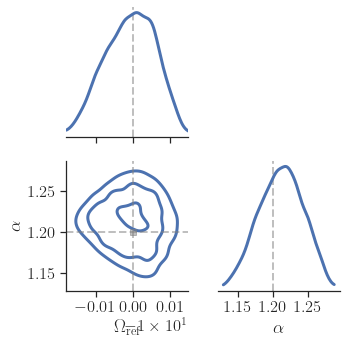

In [42]:
df = pd.DataFrame({r'$\Omega_\mathrm{ref}$': post_Omega, r'$\alpha$': post_alpha})

cls = [0.9, 0.6, 0.1]
p1 = sns.color_palette("light:C0", as_cmap=True)
hue_kws = dict(
    levels=[cls, cls],
    fill=[False, False],
    color=['#4c72b0', '#dd8452'],
    linestyles=['-', '-'],
    linewidths=[3, 3],
    alpha=[1, 1],
    zorder=[1, 1]
)
cornerresult = sns.PairGrid(df, vars=[r"$\Omega_\mathrm{ref}$", r"$\alpha$"],
             corner=True,
             palette=['C0', 'C1'],
             hue_kws=hue_kws,
             diag_sharey=False)
cornerresult.map_diag(kdeplot, auto_bound=True, linewidth=3)
cornerresult.map_lower(kdeplot, auto_bound=True, linewidth=3)


diag_index = [0, 3]
joint_index = [2]
diag_truths = [test_data['z'][0], test_data['z'][1]] 
joint_truths_h = [test_data['z'][1]]
joint_truths_v = [test_data['z'][0]]
for i, ax in enumerate(cornerresult.axes.ravel()[joint_index]):
    ax.axvline(joint_truths_v[i], ls='--', linewidth=2, c='gray', alpha=0.5)
    ax.axhline(joint_truths_h[i], ls='--', linewidth=2, c='gray', alpha=0.5)
    ax.plot(joint_truths_v[i], joint_truths_h[i], marker="s", color="gray", alpha=0.5)
for i, ax in enumerate(cornerresult.axes.ravel()[diag_index]):
    ax.axvline(diag_truths[i], ls='--', linewidth=2, c='gray', alpha=0.5)

In [43]:
print(r"SBI sigma for Omega,", np.std(10**post_Omega))
#print(r"MCMC sigma for Omega,", np.std(Omega_MCMC))

SBI sigma for Omega, 1.5142507004523718e-12


In [44]:
print(r"SBI sigma for alpha,", np.std(post_alpha))
#print(r"MCMC sigma for alpha,", np.std(alpha_MCMC))

SBI sigma for alpha, 0.03098948939092565


In [29]:
        # Uniform distribution for alphaomega_prior = stats.uniform(-10.02, 0.05)#stats.uniform(-9.2, 0.4)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(1.1,  0.2)   
# Sample 1000 points from the priors
z_omega = omega_prior.rvs(10000)
z_alpha = alpha_prior.rvs(10000)
z_samps = np.column_stack((z_omega, z_alpha))
prior_samples = swyft.Samples(z = z_samps)


coverage_samples = trainer.test_coverage(network, sims[-1000:], prior_samples[:])

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████████████████| 32/32 [00:00<00:00, 45.84it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|████████████████| 10000/10000 [07:14<00:00, 23.00it/s]


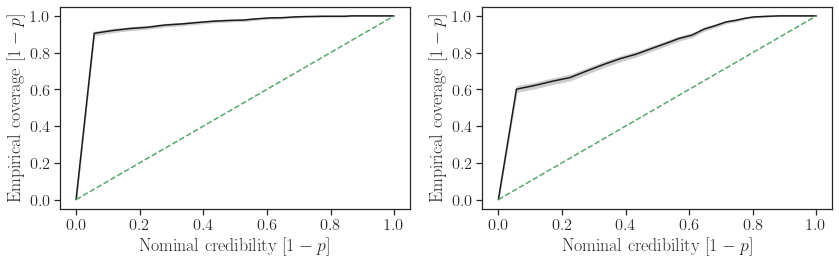

In [30]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
swyft.plot_pp(coverage_samples, "z[0]")
plt.subplot(122)
swyft.plot_pp(coverage_samples, "z[1]")
plt.tight_layout()

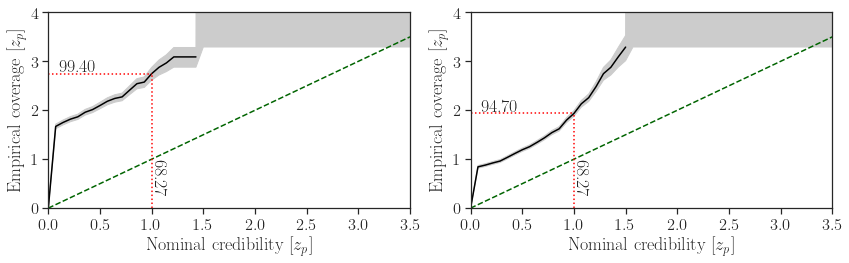

In [31]:
# zz-plot, emphasize high-credibility regionn and visualize uncertainties
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    swyft.plot_zz(coverage_samples, "z[%i]"%i, ax = axes[i])
plt.tight_layout()

# Third round

In [32]:
#bounds = swyft.collect_rect_bounds(predictions[0], 'z', parshape=(2,), threshold=1e-4)
bounds = torch.tensor([[-10.02, 9.97], [1.1, 1.3]]) 
print(bounds)

tensor([[-10.0200,   9.9700],
        [  1.1000,   1.3000]])


In [33]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [34]:
# Sample from Simulator

n_samples = 500_000
sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=bounds)
sims = sim.sample(N = n_samples)
sims['x'] = preprocess_whiten(sims['x'] , sigma)

dm = swyft.SwyftDataModule(sims, val_fraction = 0.2, batch_size = 2048)
lr_monitor = LearningRateMonitor(logging_interval='step')
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta = 0., patience=3, verbose=False, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='/scratch/haowen.zhong/SBI/logs/', filename='rings_{epoch}_{val_loss:.2f}_{train_loss:.2f}', mode='min')
logger = pl_loggers.TensorBoardLogger(save_dir='/scratch/haowen.zhong/SBI/logs/', name='AE_logs', version=None)

100%|██████████████████████████████████████████████████████| 500000/500000 [09:45<00:00, 854.64it/s]


In [53]:
ckpt = torch.load(
    "/scratch/haowen.zhong/SBI/logs/AE_logs/version_56/checkpoints/epoch=145-step=22922.ckpt",
    map_location=torch.device('cpu')
)

trainer = swyft.SwyftTrainer(accelerator = "cuda", max_epochs = 500, devices=1, auto_lr_find=True, logger=logger, callbacks=[lr_monitor, early_stopping_callback, checkpoint_callback], precision=64)
network = AE(lr=5e-7, weight_decay=1e-5, gamma=0.98, lr_scheduler_factor=0.1)#AE(lr=2e-5)#UNet(lr=2e-5, weight_decay=0.01)
network.load_state_dict(ckpt['state_dict'])
trainer.fit(network, dm)

/local/haowen.zhong/ipykernel_1665206/261035357.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(
GPU available: True (cuda), used: True
TPU available: 

Epoch 0:  80%|████████████████████████      | 196/245 [00:25<00:06,  7.71it/s, loss=-1.22, v_num=57]
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|███████████▏  | 196/245 [00:24<00:06,  7.84it/s, loss=-2.08, v_num=57, val_loss=0.717]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|███████████▏  | 196/245 [00:25<00:06,  7.69it/s, loss=-2.84, v_num=57, val_loss=-2.14]
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|███████████▏  | 196/245 [00:26<00:06,  7.35it/s, loss=-2.93, v_num=57, val_loss=-2.79]
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|█████████████▌   | 196/245 [00:25<00:06,  7.82it/s, loss=-3, v_num=57, val_loss=-2.80]
Validation: 0it [00:00, ?it/s]
Epoch 5:  80%|███████████▏  | 196/245 [00:25<00:06,  7.59it/s, loss=-3.06, v_num=57, val_loss=-2.81]
Validation: 0it [00:00, ?it/s]
Epoch 6:  80%|███████████▏  | 196/245 [00:25<00:06,  7.75it/s, loss=-3.12, v_num=57, val_loss=-2.83]
Validation: 0it [00:00, ?it/s]
Epoch 7:  80%|███████████▏  | 196/245 [00:24<00:06,  7.90it/s, loss=-3.17, v

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.

Reloading best model: /scratch/haowen.zhong/SBI/logs/AE_logs/version_57/checkpoints/epoch=15-step=3136.ckpt


In [57]:
ckpt = torch.load(
    "/scratch/haowen.zhong/SBI/logs/AE_logs/version_56/checkpoints/epoch=145-step=22922.ckpt",
    map_location=torch.device('cpu')
)
network = AE()
network.load_state_dict(ckpt['state_dict'])
network.eval()

trainer = swyft.SwyftTrainer(accelerator = 'cpu', max_epochs = 50, auto_lr_find=True, precision=64)

/local/haowen.zhong/ipykernel_1665206/1668938364.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(
GPU available: True (cuda), used: False
TPU available

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


Predicting DataLoader 0: 100%|██████████████████████████████████████| 98/98 [00:03<00:00, 27.17it/s]


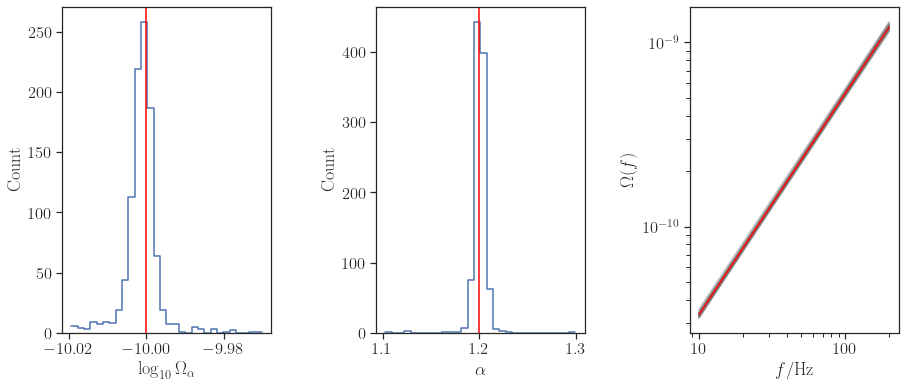

In [58]:
# Define priors
omega_prior = stats.uniform(-10.02, 0.05)#stats.uniform(-9.2, 0.4)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(1.1,  0.2)              # Uniform distribution for alpha

# Sample 1000 points from the priors
z_omega = omega_prior.rvs(100000)
z_alpha = alpha_prior.rvs(100000)

z_samps = np.column_stack((z_omega, z_alpha))

# Create prior samples
prior_samples = swyft.Samples(z = z_samps)
predictions = trainer.infer(network, test_data, prior_samples)


ln_r = np.asarray(predictions[0].logratios)
r_1 = np.exp(ln_r[:, 0])
r_2 = np.exp(ln_r[:, 1])
post_Omega = np.random.choice(z_samps[:, 0], size=1000, p = r_1/np.sum(r_1))
post_alpha = np.random.choice(z_samps[:, 1], size=1000, p = r_2/np.sum(r_2))
plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
    #plt.loglog(sim.freq, post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
    
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**test_data['z'][0]*(sim.freq/sim.fref)**test_data['z'][1], color="red")
#plt.loglog(sim.freq, test_data['z'][0, 0]*(sim.freq/sim.fref)**test_data['z'][0, 1], color="red")

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████████████████████████████████| 98/98 [00:04<00:00, 23.32it/s]


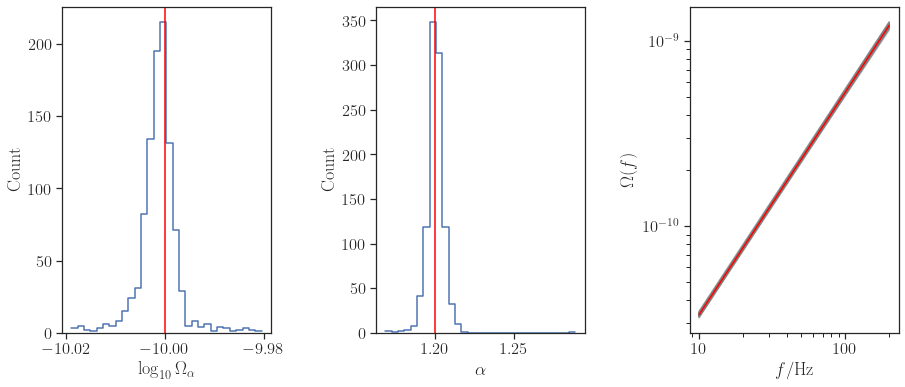

In [60]:
# Define priors
omega_prior = stats.uniform(-10.02, 0.04)#stats.uniform(-9.2, 0.4)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(1.1,  0.2)              # Uniform distribution for alpha

# Sample 1000 points from the priors
z_omega = omega_prior.rvs(100000)
z_alpha = alpha_prior.rvs(100000)

z_samps = np.column_stack((z_omega, z_alpha))

# Create prior samples
prior_samples = swyft.Samples(z = z_samps)
predictions = trainer.infer(network, test_data, prior_samples)


ln_r = np.asarray(predictions[0].logratios)
r_1 = np.exp(ln_r[:, 0])
r_2 = np.exp(ln_r[:, 1])
post_Omega = np.random.choice(z_samps[:, 0], size=1000, p = r_1/np.sum(r_1))
post_alpha = np.random.choice(z_samps[:, 1], size=1000, p = r_2/np.sum(r_2))
plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
    #plt.loglog(sim.freq, post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
    
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**test_data['z'][0]*(sim.freq/sim.fref)**test_data['z'][1], color="red")
#plt.loglog(sim.freq, test_data['z'][0, 0]*(sim.freq/sim.fref)**test_data['z'][0, 1], color="red")

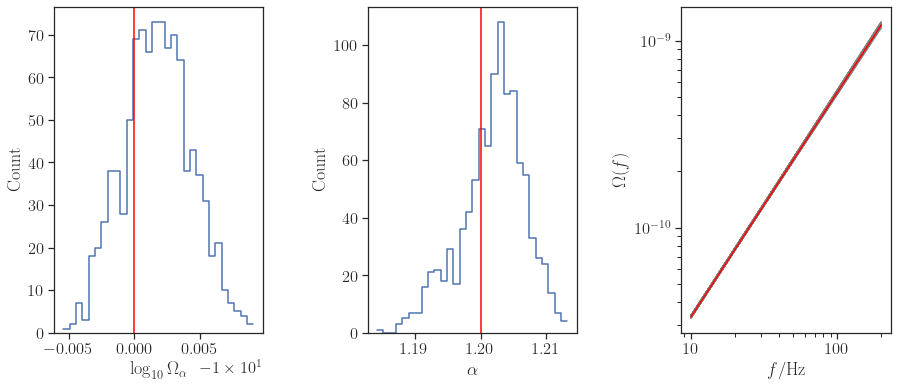

In [62]:
ln_r = np.asarray(predictions[1].logratios)
r = np.exp(ln_r).reshape([-1])

post_idx = np.random.choice(np.arange(0, 100000, 1), size=1000, p = r/np.sum(r))
post_Omega = z_samps[post_idx, 0]
post_alpha = z_samps[post_idx, 1]
plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**test_data['z'][0]*(sim.freq/sim.fref)**test_data['z'][1], color="red")

In [69]:
np.percentile(post_Omega, 1), np.percentile(post_Omega, 99)

(-10.003857978295445, -9.992331687247704)

In [70]:
np.percentile(post_alpha, 1), np.percentile(post_alpha, 99)

(1.1891861847190197, 1.211307959126649)

/local/haowen.zhong/ipykernel_1665206/1926431257.py:271: UserWarning: The following kwargs were not used by contour: 'auto_bound', 'linewidth'
  ax.contour(XS, YS, ZS, levels=l, **kws)


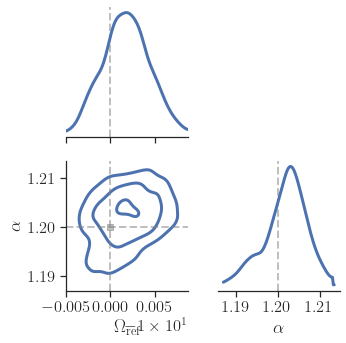

In [63]:
df = pd.DataFrame({r'$\Omega_\mathrm{ref}$': post_Omega, r'$\alpha$': post_alpha})

cls = [0.9, 0.6, 0.1]
p1 = sns.color_palette("light:C0", as_cmap=True)
hue_kws = dict(
    levels=[cls, cls],
    fill=[False, False],
    color=['#4c72b0', '#dd8452'],
    linestyles=['-', '-'],
    linewidths=[3, 3],
    alpha=[1, 1],
    zorder=[1, 1]
)
cornerresult = sns.PairGrid(df, vars=[r"$\Omega_\mathrm{ref}$", r"$\alpha$"],
             corner=True,
             palette=['C0', 'C1'],
             hue_kws=hue_kws,
             diag_sharey=False)
cornerresult.map_diag(kdeplot, auto_bound=True, linewidth=3)
cornerresult.map_lower(kdeplot, auto_bound=True, linewidth=3)


diag_index = [0, 3]
joint_index = [2]
diag_truths = [test_data['z'][0], test_data['z'][1]] 
joint_truths_h = [test_data['z'][1]]
joint_truths_v = [test_data['z'][0]]
for i, ax in enumerate(cornerresult.axes.ravel()[joint_index]):
    ax.axvline(joint_truths_v[i], ls='--', linewidth=2, c='gray', alpha=0.5)
    ax.axhline(joint_truths_h[i], ls='--', linewidth=2, c='gray', alpha=0.5)
    ax.plot(joint_truths_v[i], joint_truths_h[i], marker="s", color="gray", alpha=0.5)
for i, ax in enumerate(cornerresult.axes.ravel()[diag_index]):
    ax.axvline(diag_truths[i], ls='--', linewidth=2, c='gray', alpha=0.5)

In [64]:
print(r"SBI sigma for Omega,", np.std(10**post_Omega))
#print(r"MCMC sigma for Omega,", np.std(Omega_MCMC))

SBI sigma for Omega, 6.002600080227655e-13


In [65]:
print(r"SBI sigma for alpha,", np.std(post_alpha))
#print(r"MCMC sigma for alpha,", np.std(alpha_MCMC))

SBI sigma for alpha, 0.004864795563973961


# Fourth round

In [7]:
#bounds = swyft.collect_rect_bounds(predictions[0], 'z', parshape=(2,), threshold=1e-4)
bounds = torch.tensor([[-10.003857978295445, -9.992331687247704], [1.1891861847190197, 1.211307959126649]]) 
print(bounds)

tensor([[-10.0039,  -9.9923],
        [  1.1892,   1.2113]])


In [8]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [11]:
# Sample from Simulator

n_samples = 100_000
sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=bounds)
sims = sim.sample(N = n_samples)
sims['x'] = preprocess_whiten(sims['x'] , sigma)

dm = swyft.SwyftDataModule(sims, val_fraction = 0.2, batch_size = 2048)
lr_monitor = LearningRateMonitor(logging_interval='step')
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta = 0., patience=3, verbose=False, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='/scratch/haowen.zhong/SBI/logs/', filename='rings_{epoch}_{val_loss:.2f}_{train_loss:.2f}', mode='min')
logger = pl_loggers.TensorBoardLogger(save_dir='/scratch/haowen.zhong/SBI/logs/', name='AE_logs', version=None)

100%|██████████████████████████████████████████████████████| 100000/100000 [01:58<00:00, 840.84it/s]


In [107]:
ckpt = torch.load(
    "/scratch/haowen.zhong/SBI/logs/AE_logs/version_56/checkpoints/epoch=145-step=22922.ckpt",
    map_location=torch.device('cpu')
)

trainer = swyft.SwyftTrainer(accelerator = "cuda", max_epochs = 500, devices=1, auto_lr_find=True, logger=logger, callbacks=[lr_monitor, early_stopping_callback, checkpoint_callback], precision=64)
network = AE(lr=5e-8, weight_decay=1e-6, gamma=0.98, lr_scheduler_factor=0.1)
network.load_state_dict(ckpt['state_dict'])
trainer.fit(network, dm)

/local/haowen.zhong/ipykernel_1665206/116618758.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(
GPU available: True (cuda), used: True
TPU available: 

Epoch 0:  80%|██████████████████████████▍      | 40/50 [00:05<00:01,  7.17it/s, loss=1.97, v_num=60]
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|█████████████▌   | 40/50 [00:05<00:01,  6.88it/s, loss=1.89, v_num=60, val_loss=1.960]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|█████████████▌   | 40/50 [00:05<00:01,  7.34it/s, loss=1.82, v_num=60, val_loss=1.920]
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|█████████████▌   | 40/50 [00:05<00:01,  7.30it/s, loss=1.76, v_num=60, val_loss=1.910]
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|█████████████▌   | 40/50 [00:05<00:01,  7.46it/s, loss=1.71, v_num=60, val_loss=1.930]
Validation: 0it [00:00, ?it/s]
Epoch 5:  80%|█████████████▌   | 40/50 [00:06<00:01,  6.44it/s, loss=1.66, v_num=60, val_loss=1.950]
Validation: 0it [00:00, ?it/s]
Epoch 6:  80%|█████████████▌   | 40/50 [00:05<00:01,  7.38it/s, loss=1.61, v_num=60, val_loss=1.930]
Validation: 0it [00:00, ?it/s]
Epoch 7:  80%|█████████████▌   | 40/50 [00:05<00:01,  7.28it/s, loss=1.57, v

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 499:  80%|██████████▍  | 40/50 [00:05<00:01,  7.36it/s, loss=-0.996, v_num=60, val_loss=-.191]
Validation: 0it [00:00, ?it/s]
Epoch 499: 100%|█████████████| 50/50 [00:06<00:00,  7.78it/s, loss=-0.996, v_num=60, val_loss=-.195]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|█████████████| 50/50 [00:07<00:00,  6.34it/s, loss=-0.996, v_num=60, val_loss=-.195]
Reloading best model: /scratch/haowen.zhong/SBI/logs/AE_logs/version_60/checkpoints/epoch=499-step=20000.ckpt


In [108]:
ckpt = torch.load(
    "/scratch/haowen.zhong/SBI/logs/AE_logs/version_60/checkpoints/epoch=499-step=20000.ckpt",
    map_location=torch.device('cpu')
)
network = AE()
network.load_state_dict(ckpt['state_dict'])
network.eval()

trainer = swyft.SwyftTrainer(accelerator = 'cpu', max_epochs = 50, auto_lr_find=True, precision=64)

/local/haowen.zhong/ipykernel_1665206/986276711.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(
GPU available: True (cuda), used: False
TPU available:

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


Predicting DataLoader 0: 100%|██████████████████████████████████████| 98/98 [00:05<00:00, 18.69it/s]


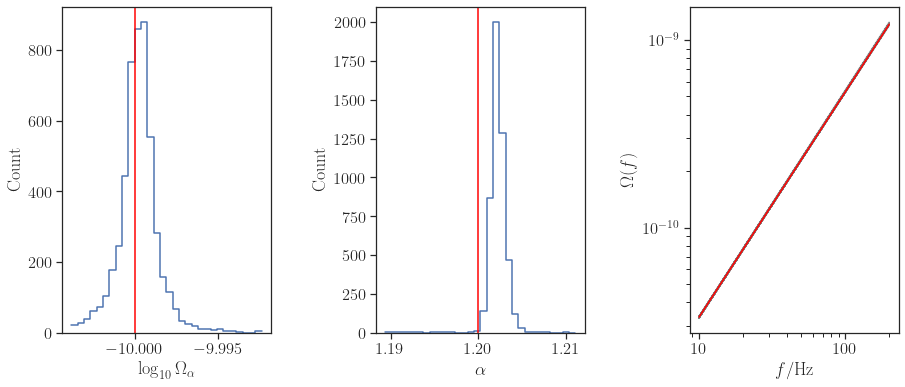

In [109]:
# Define priors
omega_prior = stats.uniform(-10.003857978295445, 0.0115262910477405)#stats.uniform(-9.2, 0.4)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(1.1891861847190197,  0.02212177440762919)              # Uniform distribution for alpha

# Sample 1000 points from the priors
z_omega = omega_prior.rvs(100000)
z_alpha = alpha_prior.rvs(100000)

z_samps = np.column_stack((z_omega, z_alpha))

# Create prior samples
prior_samples = swyft.Samples(z = z_samps)
predictions = trainer.infer(network, test_data, prior_samples)


ln_r = np.asarray(predictions[0].logratios)
r_1 = np.exp(ln_r[:, 0])
r_2 = np.exp(ln_r[:, 1])
post_Omega = np.random.choice(z_samps[:, 0], size=5000, p = r_1/np.sum(r_1))
post_alpha = np.random.choice(z_samps[:, 1], size=5000, p = r_2/np.sum(r_2))
plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
    #plt.loglog(sim.freq, post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
    
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**test_data['z'][0]*(sim.freq/sim.fref)**test_data['z'][1], color="red")
#plt.loglog(sim.freq, test_data['z'][0, 0]*(sim.freq/sim.fref)**test_data['z'][0, 1], color="red")

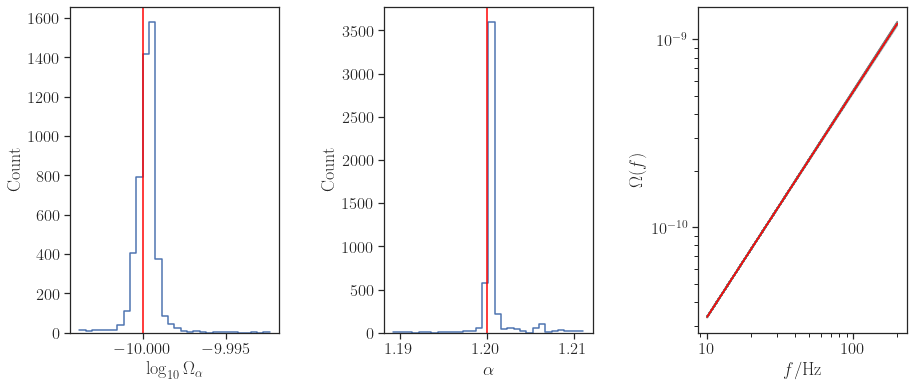

In [110]:
ln_r = np.asarray(predictions[1].logratios)
r = np.exp(ln_r).reshape([-1])

post_idx = np.random.choice(np.arange(0, 100000, 1), size=5000, p = r/np.sum(r))
post_Omega = z_samps[post_idx, 0]
post_alpha = z_samps[post_idx, 1]
plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**test_data['z'][0]*(sim.freq/sim.fref)**test_data['z'][1], color="red")

/local/haowen.zhong/ipykernel_1665206/1926431257.py:271: UserWarning: The following kwargs were not used by contour: 'auto_bound', 'linewidth'
  ax.contour(XS, YS, ZS, levels=l, **kws)


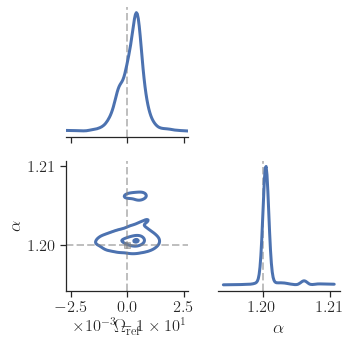

In [111]:
df = pd.DataFrame({r'$\Omega_\mathrm{ref}$': post_Omega, r'$\alpha$': post_alpha})

cls = [0.9, 0.6, 0.1]
p1 = sns.color_palette("light:C0", as_cmap=True)
hue_kws = dict(
    levels=[cls, cls],
    fill=[False, False],
    color=['#4c72b0', '#dd8452'],
    linestyles=['-', '-'],
    linewidths=[3, 3],
    alpha=[1, 1],
    zorder=[1, 1]
)
cornerresult = sns.PairGrid(df, vars=[r"$\Omega_\mathrm{ref}$", r"$\alpha$"],
             corner=True,
             palette=['C0', 'C1'],
             hue_kws=hue_kws,
             diag_sharey=False)
cornerresult.map_diag(kdeplot, auto_bound=True, linewidth=3)
cornerresult.map_lower(kdeplot, auto_bound=True, linewidth=3)


diag_index = [0, 3]
joint_index = [2]
diag_truths = [test_data['z'][0], test_data['z'][1]] 
joint_truths_h = [test_data['z'][1]]
joint_truths_v = [test_data['z'][0]]
for i, ax in enumerate(cornerresult.axes.ravel()[joint_index]):
    ax.axvline(joint_truths_v[i], ls='--', linewidth=2, c='gray', alpha=0.5)
    ax.axhline(joint_truths_h[i], ls='--', linewidth=2, c='gray', alpha=0.5)
    ax.plot(joint_truths_v[i], joint_truths_h[i], marker="s", color="gray", alpha=0.5)
for i, ax in enumerate(cornerresult.axes.ravel()[diag_index]):
    ax.axvline(diag_truths[i], ls='--', linewidth=2, c='gray', alpha=0.5)

In [112]:
print(r"SBI sigma for Omega,", np.std(10**post_Omega))
#print(r"MCMC sigma for Omega,", np.std(Omega_MCMC))

SBI sigma for Omega, 1.716284409829532e-13


In [113]:
print(r"SBI sigma for alpha,", np.std(post_alpha))
#print(r"MCMC sigma for alpha,", np.std(alpha_MCMC))

SBI sigma for alpha, 0.0019736416801705973


# Fourth round train it again?

In [ ]:
ckpt = torch.load(
    "/scratch/haowen.zhong/SBI/logs/AE_logs/version_56/checkpoints/epoch=145-step=22922.ckpt",
    map_location=torch.device('cpu')
)

trainer = swyft.SwyftTrainer(accelerator = "cuda", max_epochs = 1000, devices=1, auto_lr_find=True, logger=logger, callbacks=[lr_monitor, early_stopping_callback, checkpoint_callback], precision=64)
network = AE(lr=5e-8, weight_decay=1e-6, gamma=0.98, lr_scheduler_factor=0.1)#AE(lr=2e-5)#UNet(lr=2e-5, weight_decay=0.01)
network.load_state_dict(ckpt['state_dict'])
trainer.fit(network, dm)

/local/haowen.zhong/ipykernel_2612030/3410145949.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(
GPU available: True (cuda), used: True
TPU available:

Sanity Checking DataLoader 0:   0%|                                           | 0/2 [00:00<?, ?it/s]

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  80%|██████████████████████████▍      | 40/50 [00:06<00:01,  6.25it/s, loss=1.97, v_num=61]
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|██████████████▍   | 40/50 [00:06<00:01,  6.59it/s, loss=1.9, v_num=61, val_loss=1.920]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|█████████████▌   | 40/50 [00:06<00:01,  5.89it/s, loss=1.84, v_num=61, val_loss=1.920]
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|█████████████▌   | 40/50 [00:05<00:01,  6.77it/s, loss=1.78, v_num=61, val_loss=1.930]
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|█████████████▌   | 40/50 [00:06<00:01,  6.25it/s, loss=1.72, v_num=61, val_loss=1.920]
Validation: 0it [00:00, ?it/s]
Epoch 5:  80%|█████████████▌   | 40/50 [00:05<00:01,  7.36it/s, loss=1.67, v_num=61, val_loss=1.910]
Validation: 0it [00:00, ?it/s]
Epoch 6:  80%|█████████████▌   | 40/50 [00:05<00:01,  7.30it/s, loss=1.63, v_num=61, val_loss=1.910]
Validation: 0it [00:00, ?it/s]
Epoch 7:  80%|█████████████▌   | 40/50 [00:17<00:04,  2.26it/s, loss=1.59, v

In [14]:
ckpt = torch.load(
    "/scratch/haowen.zhong/SBI/logs/AE_logs/version_61/checkpoints/epoch=676-step=27080.ckpt",
    map_location=torch.device('cpu')
)
network = AE()
network.load_state_dict(ckpt['state_dict'])
network.eval()

trainer = swyft.SwyftTrainer(accelerator = 'cpu', max_epochs = 50, auto_lr_find=True, precision=64)

/local/haowen.zhong/ipykernel_2612030/2690297639.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(
GPU available: True (cuda), used: False
TPU available

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


Predicting DataLoader 0:   1%|▍                                      | 1/98 [00:00<00:09,  9.75it/s]

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting DataLoader 0: 100%|██████████████████████████████████████| 98/98 [00:03<00:00, 29.56it/s]


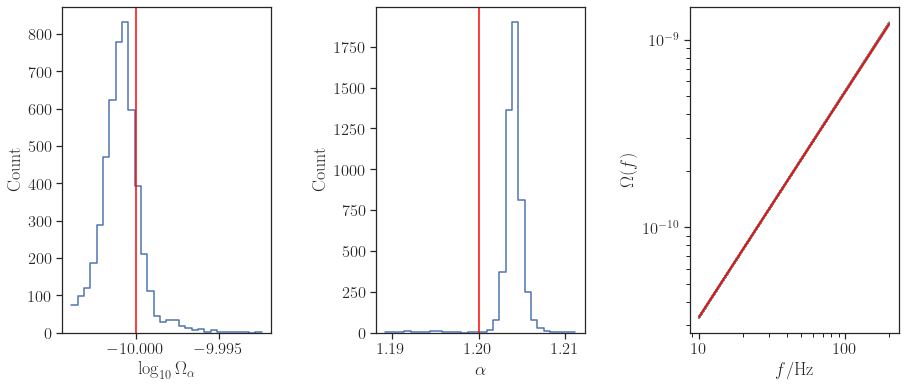

In [17]:
# Define priors
omega_prior = stats.uniform(-10.003857978295445, 0.0115262910477405)#stats.uniform(-9.2, 0.4)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(1.1891861847190197,  0.02212177440762919)              # Uniform distribution for alpha

# Sample 1000 points from the priors
z_omega = omega_prior.rvs(100000)
z_alpha = alpha_prior.rvs(100000)

z_samps = np.column_stack((z_omega, z_alpha))

# Create prior samples
prior_samples = swyft.Samples(z = z_samps)
predictions = trainer.infer(network, test_data, prior_samples)


ln_r = np.asarray(predictions[0].logratios)
r_1 = np.exp(ln_r[:, 0])
r_2 = np.exp(ln_r[:, 1])
post_Omega = np.random.choice(z_samps[:, 0], size=5000, p = r_1/np.sum(r_1))
post_alpha = np.random.choice(z_samps[:, 1], size=5000, p = r_2/np.sum(r_2))
plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
    #plt.loglog(sim.freq, post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
    
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**test_data['z'][0]*(sim.freq/sim.fref)**test_data['z'][1], color="red")
#plt.loglog(sim.freq, test_data['z'][0, 0]*(sim.freq/sim.fref)**test_data['z'][0, 1], color="red")

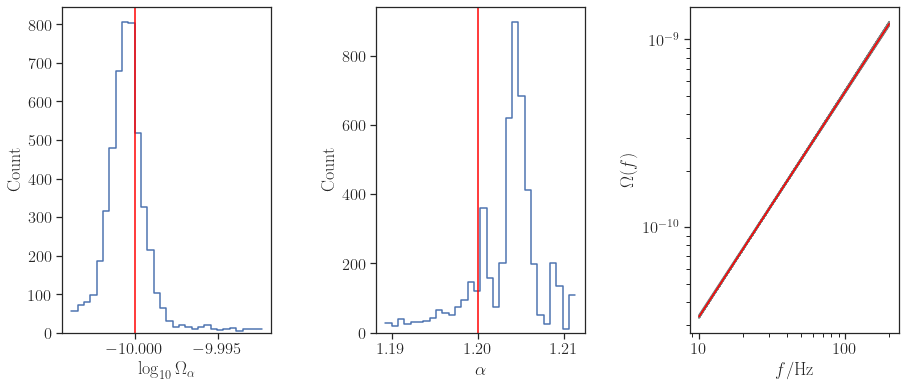

In [18]:
ln_r = np.asarray(predictions[1].logratios)
r = np.exp(ln_r).reshape([-1])

post_idx = np.random.choice(np.arange(0, 100000, 1), size=5000, p = r/np.sum(r))
post_Omega = z_samps[post_idx, 0]
post_alpha = z_samps[post_idx, 1]
plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**test_data['z'][0]*(sim.freq/sim.fref)**test_data['z'][1], color="red")

/local/haowen.zhong/ipykernel_2612030/1926431257.py:271: UserWarning: The following kwargs were not used by contour: 'auto_bound', 'linewidth'
  ax.contour(XS, YS, ZS, levels=l, **kws)


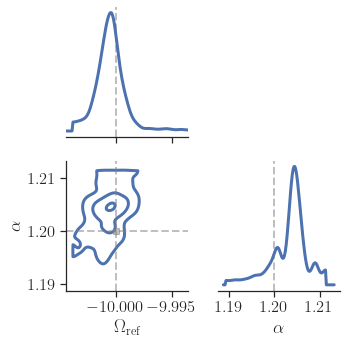

In [19]:
df = pd.DataFrame({r'$\Omega_\mathrm{ref}$': post_Omega, r'$\alpha$': post_alpha})

cls = [0.9, 0.6, 0.1]
p1 = sns.color_palette("light:C0", as_cmap=True)
hue_kws = dict(
    levels=[cls, cls],
    fill=[False, False],
    color=['#4c72b0', '#dd8452'],
    linestyles=['-', '-'],
    linewidths=[3, 3],
    alpha=[1, 1],
    zorder=[1, 1]
)
cornerresult = sns.PairGrid(df, vars=[r"$\Omega_\mathrm{ref}$", r"$\alpha$"],
             corner=True,
             palette=['C0', 'C1'],
             hue_kws=hue_kws,
             diag_sharey=False)
cornerresult.map_diag(kdeplot, auto_bound=True, linewidth=3)
cornerresult.map_lower(kdeplot, auto_bound=True, linewidth=3)


diag_index = [0, 3]
joint_index = [2]
diag_truths = [test_data['z'][0], test_data['z'][1]] 
joint_truths_h = [test_data['z'][1]]
joint_truths_v = [test_data['z'][0]]
for i, ax in enumerate(cornerresult.axes.ravel()[joint_index]):
    ax.axvline(joint_truths_v[i], ls='--', linewidth=2, c='gray', alpha=0.5)
    ax.axhline(joint_truths_h[i], ls='--', linewidth=2, c='gray', alpha=0.5)
    ax.plot(joint_truths_v[i], joint_truths_h[i], marker="s", color="gray", alpha=0.5)
for i, ax in enumerate(cornerresult.axes.ravel()[diag_index]):
    ax.axvline(diag_truths[i], ls='--', linewidth=2, c='gray', alpha=0.5)

In [20]:
print(r"SBI sigma for Omega,", np.std(10**post_Omega))
#print(r"MCMC sigma for Omega,", np.std(Omega_MCMC))

SBI sigma for Omega, 3.2754570358274864e-13


In [21]:
print(r"SBI sigma for alpha,", np.std(post_alpha))
#print(r"MCMC sigma for alpha,", np.std(alpha_MCMC))

SBI sigma for alpha, 0.003955979555768462


# What if the target is $\log\Omega=-11, \alpha=0.5$?

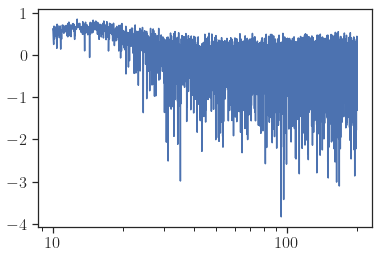

In [9]:
#bounds = swyft.collect_rect_bounds(predictions[0], 'z', parshape=(2,), threshold=1e-4)
# bounds = torch.tensor([[-11.01, -10.99], [0.49, 0.51]]) 
# print(bounds)
test_data = sim.sample(conditions={'z':[-11, 0.5]})
test_data['x'] = test_data['x'].reshape([1, 6081])
test_data['x'] = preprocess_whiten(test_data['x'] , sigma)
test_data['x'] = test_data['x'][0]
plt.semilogx(sim.freq, test_data['x'])

In [10]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [12]:
# Sample from Simulator

n_samples = 50_000
sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
sims = sim.sample(N = n_samples)
sims['x'] = preprocess_whiten(sims['x'] , sigma)

dm = swyft.SwyftDataModule(sims, val_fraction = 0.2, batch_size = 2048)
lr_monitor = LearningRateMonitor(logging_interval='step')
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta = 0., patience=3, verbose=False, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='/scratch/haowen.zhong/SBI/logs/', filename='rings_{epoch}_{val_loss:.2f}_{train_loss:.2f}', mode='min')
logger = pl_loggers.TensorBoardLogger(save_dir='/scratch/haowen.zhong/SBI/logs/', name='AE_logs', version=None)

100%|████████████████████████████████████| 50000/50000 [01:01<00:00, 810.82it/s]


In [13]:
trainer = swyft.SwyftTrainer(accelerator = "cuda", max_epochs = 500, devices=1, auto_lr_find=True, logger=logger, callbacks=[lr_monitor, early_stopping_callback, checkpoint_callback], precision=64)
network = AE(lr=1e-5, weight_decay=1e-6, gamma=0.98, lr_scheduler_factor=0.1)
trainer.fit(network, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type                   | Params
--------------------------------------------------------
0 | summarizer   | Sequential             | 35.7 M
1 | logratios_1D | LogRatioEstimator_1dim | 35.2 K
2 | logratios_2D | LogRatioEstimator_Ndim | 34.8 K
-------------------

Sanity Checking DataLoader 0:   0%|                       | 0/2 [00:00<?, ?it/s]

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  80%|████████  | 20/25 [00:03<00:00,  5.98it/s, loss=0.00427, v_num=63]
Validation: 0it [00:00, ?it/s]
Epoch 0:  96%|█████████▌| 24/25 [00:03<00:00,  6.46it/s, loss=0.00427, v_num=63]
Epoch 0: 100%|█| 25/25 [00:03<00:00,  6.57it/s, loss=0.00427, v_num=63, val_loss
Epoch 1:  80%|▊| 20/25 [00:02<00:00,  7.38it/s, loss=0.00242, v_num=63, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/5 [00:00<?, ?it/s]
Epoch 1:  84%|▊| 21/25 [00:02<00:00,  7.52it/s, loss=0.00242, v_num=63, val_loss
Epoch 1:  88%|▉| 22/25 [00:02<00:00,  7.63it/s, loss=0.00242, v_num=63, val_loss
Epoch 1:  92%|▉| 23/25 [00:03<00:00,  7.66it/s, loss=0.00242, v_num=63, val_loss
Epoch 1:  96%|▉| 24/25 [00:03<00:00,  7.76it/s, loss=0.00242, v_num=63, val_loss
Epoch 1: 100%|█| 25/25 [00:03<00:00,  7.86it/s, loss=0.00242, v_num=63, val_loss
Epoch 2:  80%|▊| 20/25 [00:02<00:00,  7.40it/s, loss=0.000914, v_num=63, val_los
Validation: 0it [00:00, ?it/s]
Validation DataL

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.

Reloading best model: /scratch/haowen.zhong/SBI/logs/AE_logs/version_63/checkpoints/epoch=111-step=2240.ckpt


In [13]:
ckpt = torch.load(
    "/scratch/haowen.zhong/SBI/logs/AE_logs/version_62/checkpoints/epoch=155-step=6240.ckpt",
    map_location=torch.device('cpu')
)
network = AE()
network.load_state_dict(ckpt['state_dict'])
network.eval()

trainer = swyft.SwyftTrainer(accelerator = 'cpu', max_epochs = 50, auto_lr_find=True, precision=64)

/local/haowen.zhong/ipykernel_4007924/2355321784.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(
GPU available: True (cuda), used: False
TPU available

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████████████| 98/98 [00:08<00:00, 11.64it/s]


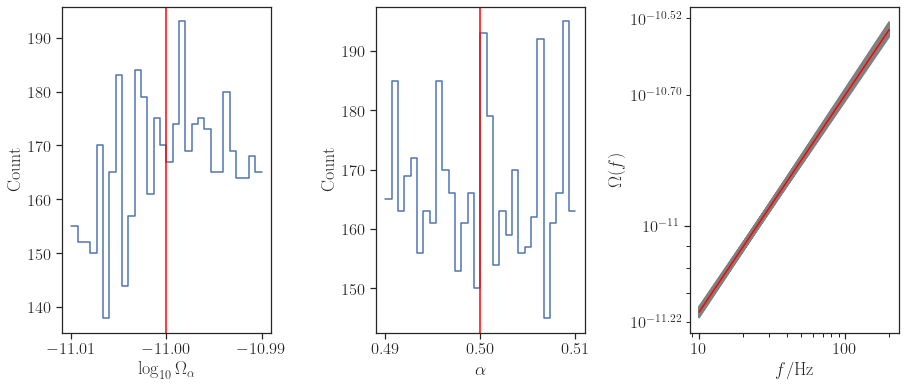

In [15]:
# Define priors
bounds = torch.tensor([[-11.01, -10.99], [0.49, 0.51]]) 
omega_prior = stats.uniform(-11.01, 0.02)#stats.uniform(-9.2, 0.4)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(0.49, 0.02)              # Uniform distribution for alpha

# Sample 1000 points from the priors
z_omega = omega_prior.rvs(100000)
z_alpha = alpha_prior.rvs(100000)

z_samps = np.column_stack((z_omega, z_alpha))

# Create prior samples
prior_samples = swyft.Samples(z = z_samps)
predictions = trainer.infer(network, test_data, prior_samples)


ln_r = np.asarray(predictions[0].logratios)
r_1 = np.exp(ln_r[:, 0])
r_2 = np.exp(ln_r[:, 1])
post_Omega = np.random.choice(z_samps[:, 0], size=5000, p = r_1/np.sum(r_1))
post_alpha = np.random.choice(z_samps[:, 1], size=5000, p = r_2/np.sum(r_2))
plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
    #plt.loglog(sim.freq, post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
    
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**test_data['z'][0]*(sim.freq/sim.fref)**test_data['z'][1], color="red")
#plt.loglog(sim.freq, test_data['z'][0, 0]*(sim.freq/sim.fref)**test_data['z'][0, 1], color="red")

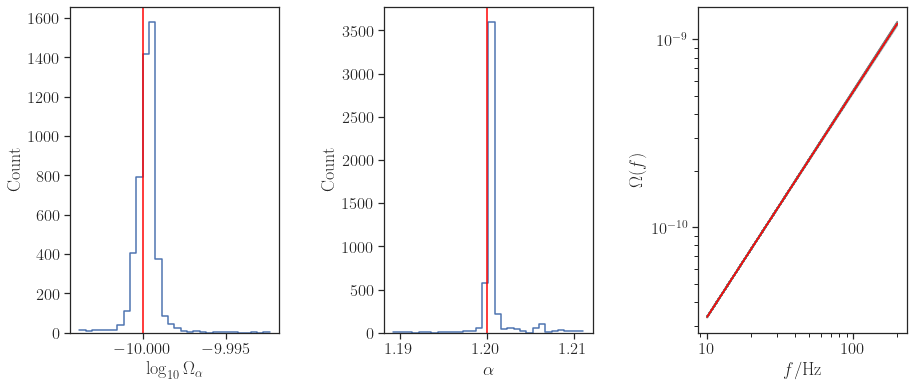

In [110]:
ln_r = np.asarray(predictions[1].logratios)
r = np.exp(ln_r).reshape([-1])

post_idx = np.random.choice(np.arange(0, 100000, 1), size=5000, p = r/np.sum(r))
post_Omega = z_samps[post_idx, 0]
post_alpha = z_samps[post_idx, 1]
plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(test_data['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**test_data['z'][0]*(sim.freq/sim.fref)**test_data['z'][1], color="red")

/local/haowen.zhong/ipykernel_1665206/1926431257.py:271: UserWarning: The following kwargs were not used by contour: 'auto_bound', 'linewidth'
  ax.contour(XS, YS, ZS, levels=l, **kws)


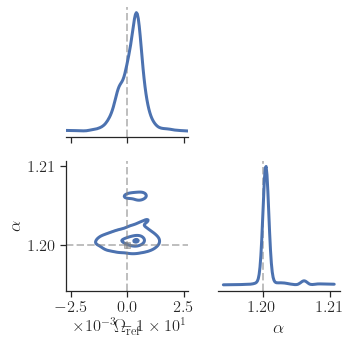

In [111]:
df = pd.DataFrame({r'$\Omega_\mathrm{ref}$': post_Omega, r'$\alpha$': post_alpha})

cls = [0.9, 0.6, 0.1]
p1 = sns.color_palette("light:C0", as_cmap=True)
hue_kws = dict(
    levels=[cls, cls],
    fill=[False, False],
    color=['#4c72b0', '#dd8452'],
    linestyles=['-', '-'],
    linewidths=[3, 3],
    alpha=[1, 1],
    zorder=[1, 1]
)
cornerresult = sns.PairGrid(df, vars=[r"$\Omega_\mathrm{ref}$", r"$\alpha$"],
             corner=True,
             palette=['C0', 'C1'],
             hue_kws=hue_kws,
             diag_sharey=False)
cornerresult.map_diag(kdeplot, auto_bound=True, linewidth=3)
cornerresult.map_lower(kdeplot, auto_bound=True, linewidth=3)


diag_index = [0, 3]
joint_index = [2]
diag_truths = [test_data['z'][0], test_data['z'][1]] 
joint_truths_h = [test_data['z'][1]]
joint_truths_v = [test_data['z'][0]]
for i, ax in enumerate(cornerresult.axes.ravel()[joint_index]):
    ax.axvline(joint_truths_v[i], ls='--', linewidth=2, c='gray', alpha=0.5)
    ax.axhline(joint_truths_h[i], ls='--', linewidth=2, c='gray', alpha=0.5)
    ax.plot(joint_truths_v[i], joint_truths_h[i], marker="s", color="gray", alpha=0.5)
for i, ax in enumerate(cornerresult.axes.ravel()[diag_index]):
    ax.axvline(diag_truths[i], ls='--', linewidth=2, c='gray', alpha=0.5)

In [112]:
print(r"SBI sigma for Omega,", np.std(10**post_Omega))
#print(r"MCMC sigma for Omega,", np.std(Omega_MCMC))

SBI sigma for Omega, 1.716284409829532e-13


In [113]:
print(r"SBI sigma for alpha,", np.std(post_alpha))
#print(r"MCMC sigma for alpha,", np.std(alpha_MCMC))

SBI sigma for alpha, 0.0019736416801705973
